In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import grangercausalitytests


In [2]:

def load_and_process_data(file_path):
    df = pd.read_csv(file_path)
    df.set_index(pd.to_datetime(df['time']), inplace=True)
    df.drop(['Unnamed: 0','time'], axis = 1, inplace=True)
    return df


In [3]:

def calculate_percentage_change(df):
    for ticker in ['BTC','ETH']:
        df[f'perc_{ticker}_change_1hr'] = ((df[f'{ticker}_close']-df[f'{ticker}_open'])/df[f'{ticker}_open'])*100
        for i in np.arange(1,7):
            df[f'perc_{ticker}_change_{i}hr'] = (df[f'{ticker}_close'].diff(i)/df[f'{ticker}_close'].shift(i)) * 100
    return df


In [4]:

def perform_clustering(df):
    X = df[[f'perc_{ticker}_change_6hr' for ticker in ['BTC','ETH']]]
    X.dropna(inplace=True)
    km = KMeans(n_clusters=5, random_state=42)
    km.fit(X)
    return km, X


In [5]:

def visualize_clusters(km, X):
    y_pred = km.predict(X)
    plt.figure(figsize=(10, 7))
    for i in range(km.n_clusters):
        cluster_i = X[y_pred == i]
        plt.scatter(cluster_i.iloc[:, 0], cluster_i.iloc[:, 1], label=f'Cluster {i}')
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=300, c='red', label = 'Centroids')
    plt.title('Clusters')
    plt.xlabel('perc_BTC_change_6hr') 
    plt.ylabel('perc_ETH_change_6hr') 
    plt.legend()
    plt.show()


In [6]:

def perform_granger_causality_tests(df):
    df.dropna(inplace=True)
    maxlag=7
    test_result = grangercausalitytests(df[['perc_BTC_change_1hr', 'perc_ETH_change_1hr']], maxlag=maxlag)
    return test_result


In [7]:

def find_windows_after_rise(df, threshold):
    def get_next_6hr_window(df, index):
        if index+6 < len(df):
            return df.iloc[index:index+6]
        else:
            return None
    windows_after_rise = pd.DataFrame()
    for i in range(len(df) - 1):
        if df['perc_BTC_change_1hr'].iloc[i] > threshold:
            window = get_next_6hr_window(df, i)
            if window is not None:
                windows_after_rise = windows_after_rise.append(window)
    return windows_after_rise


In [8]:

def find_lag_times(windows_after_rise, threshold):
    lag_times = []
    met_thresholds = []
    for i in range(0, len(windows_after_rise), 6):
        window = windows_after_rise.iloc[i:i+6]
        for i in np.arange(1,6):
            window_itr = window[window[f'perc_ETH_change_{i}hr'] > threshold][f'perc_ETH_change_{i}hr']
            if not window_itr.empty: 
                rise_time = window_itr.idxmax()
                lag_time = rise_time - window.index[0]
                met_threshold = int(1)
            else:
                lag_time = timedelta(0)
                met_threshold = int(0)
            lag_times.append(lag_time)
            met_thresholds.append(met_threshold)
        for a in range(5):
            lag_times.append(None)
            met_thresholds.append(None)
    lag_times_df = pd.DataFrame({
        'lag_time': lag_times,
        'met_threshold': met_thresholds
    })
    return lag_times_df


C:\Users\ssaam\AppData\Local\Temp\ipykernel_2152\1762914955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)
C:\Users\ssaam\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


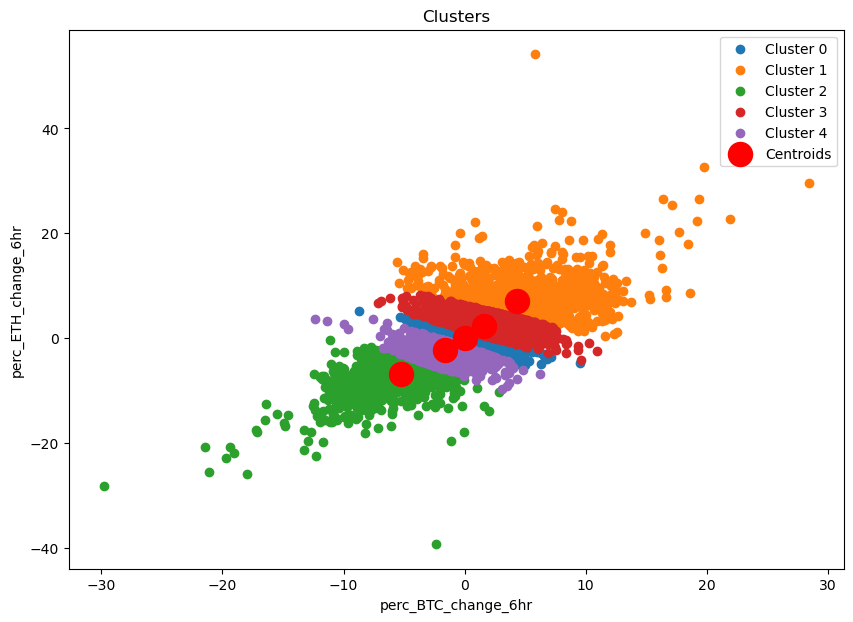


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.1548 , p=0.0002  , df_denom=58075, df_num=1
ssr based chi2 test:   chi2=14.1555 , p=0.0002  , df=1
likelihood ratio test: chi2=14.1538 , p=0.0002  , df=1
parameter F test:         F=14.1548 , p=0.0002  , df_denom=58075, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.4626  , p=0.0006  , df_denom=58072, df_num=2
ssr based chi2 test:   chi2=14.9265 , p=0.0006  , df=2
likelihood ratio test: chi2=14.9245 , p=0.0006  , df=2
parameter F test:         F=7.4626  , p=0.0006  , df_denom=58072, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3188  , p=0.0012  , df_denom=58069, df_num=3
ssr based chi2 test:   chi2=15.9582 , p=0.0012  , df=3
likelihood ratio test: chi2=15.9560 , p=0.0012  , df=3
parameter F test:         F=5.3188  , p=0.0012  , df_denom=58069, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.9968  

C:\Users\ssaam\AppData\Local\Temp\ipykernel_2152\751563007.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows_after_rise = windows_after_rise.append(window)
C:\Users\ssaam\AppData\Local\Temp\ipykernel_2152\751563007.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows_after_rise = windows_after_rise.append(window)
C:\Users\ssaam\AppData\Local\Temp\ipykernel_2152\751563007.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows_after_rise = windows_after_rise.append(window)
C:\Users\ssaam\AppData\Local\Temp\ipykernel_2152\751563007.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows_after_rise = windows_af

C:\Users\ssaam\AppData\Local\Temp\ipykernel_2152\751563007.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows_after_rise = windows_after_rise.append(window)
C:\Users\ssaam\AppData\Local\Temp\ipykernel_2152\751563007.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows_after_rise = windows_after_rise.append(window)
C:\Users\ssaam\AppData\Local\Temp\ipykernel_2152\751563007.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows_after_rise = windows_after_rise.append(window)
C:\Users\ssaam\AppData\Local\Temp\ipykernel_2152\751563007.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows_after_rise = windows_af

TypeError: '<' not supported between instances of 'int' and 'Timestamp'

In [9]:

df = load_and_process_data('../data/merged_data/ETH.csv')
df = calculate_percentage_change(df)
km, X = perform_clustering(df)
visualize_clusters(km, X)
test_result = perform_granger_causality_tests(df)
windows_after_rise = find_windows_after_rise(df, threshold=5)
lag_times_df = find_lag_times(windows_after_rise, threshold=3)
target_df = windows_after_rise.join(lag_times_df, how='left')
